# Several code snippets for the pizza project

The data can be downloaded from the page: http://pizzagan.csail.mit.edu/

There are two types of data: synthetic and real. Use the dataset you want, but beware that they do not have the same labels. They were not originally used for label prediction.



## Connection to your drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

DATA_DIR =  '/content/gdrive/MyDrive/teaching/pizza'


Mounted at /content/gdrive/


## Useful libraries

In [2]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

#import shutil

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn

#!pip install torchmetrics
#from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (torch.cuda.is_available()):
  !nvidia-smi

Fri Mar 15 17:29:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Managing data

### Load and uncompress the archive on Gdrive (rather than on your own desktop)
Uncomment the following line to do it.

In [3]:
!wget -P /content/gdrive/MyDrive/teaching/pizza/ http://pizzagan.csail.mit.edu/pizzaGANsyntheticdata.zip
!unzip '/content/gdrive/MyDrive/teaching/pizza/pizzaGANsyntheticdata.zip' -d '/content/gdrive/MyDrive/teaching/pizza/'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/3918.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/4100.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/2272.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/3432.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/3840.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/3395.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/0955.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/0527.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/0280.png  
  inflating: /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images/136

### Read data

and build the train and test dataset

In [4]:
y_all = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/train/trainLabels.txt'))
x_all = np.arange(y_all.shape[0])

# Create train, val and test splits
# x_train and x_val only contain image number (not the raw data)

x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=123)

print(y_train.shape)

y_test = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/test/testLabels.txt'))
x_test = np.arange(y_test.shape[0])

print(y_test.shape)


(3976, 10)
(497, 10)


In [5]:
x_train

array([3077, 4919, 3637, ..., 1346, 3454, 3582])

### Display one sample image

0046.png


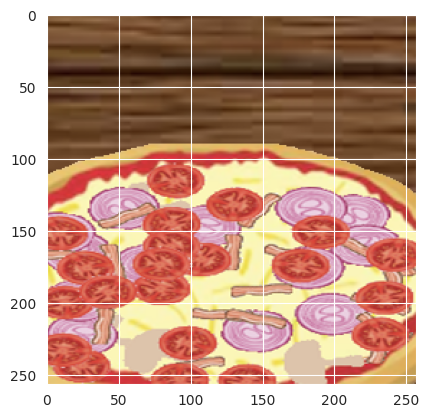

In [6]:
idx = 45

img_name = "{:04d}.png".format(idx+1)
print(img_name)

img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img = Image.open(os.path.join(img_path, img_name))

plt.imshow(img)
plt.show()

### Store train images in memory

This should make learning faster.

In [7]:
train_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train')

# Test if the numpy file exists
if (os.path.exists(os.path.join(train_data_path, 'img_data_224.npz'))):
  img_data_tensor = np.load(os.path.join(train_data_path, 'img_data_224.npz'))
  img_all = img_data_tensor['img_data']
else:
  img_all = []

  for idx in tqdm(x_all):
      img_name = "{:04d}.png".format(idx+1)
      x = Image.open(os.path.join(train_data_path, 'images', img_name))
      img_all.append(np.array(x.resize((224,224))))

  np.savez_compressed(os.path.join(train_data_path,'img_data_224.npz'), img_data=np.array(img_all))

100%|██████████| 4971/4971 [00:37<00:00, 130.87it/s]


### Dataset class

In [8]:
class myDataset(Dataset):
    """Pizza dataset"""

    def __init__(self, x_idx, y, img_path='/content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images', img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data

    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.float32(y)
      return x, y

    def __len__(self):
        return int(len(self.x_idx))


### Data loaders

In [9]:
batch_size = 25

input_size = 224

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])

kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}

train_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img_data_train = [img_all[idx] for idx in x_train]

train_set_raw = myDataset(x_train, y_train, img_path=train_data_path, img_data=img_data_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs)

img_data_val = [img_all[idx] for idx in x_val]
val_set_raw = myDataset(x_val, y_val, img_path=train_data_path, img_data=img_data_val, transform = val_transform)
val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

test_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')

test_set_raw = myDataset(x_test, y_test, img_path=test_data_path, transform = val_transform)
test_dataloader = DataLoader(test_set_raw, batch_size=batch_size, shuffle=False, **kwargs)


array([[[128,  89,  57],
        [126,  87,  55],
        [118,  78,  46],
        ...,
        [132,  95,  59],
        [132,  95,  59],
        [131,  94,  58]],

       [[129,  90,  58],
        [127,  88,  56],
        [118,  78,  47],
        ...,
        [133,  95,  60],
        [133,  95,  61],
        [130,  94,  58]],

       [[129,  90,  58],
        [127,  88,  56],
        [118,  78,  47],
        ...,
        [135,  97,  62],
        [133,  96,  60],
        [131,  93,  58]],

       ...,

       [[107,  70,  40],
        [104,  69,  38],
        [107,  72,  42],
        ...,
        [254, 212, 150],
        [253, 212, 149],
        [253, 212, 147]],

       [[106,  70,  39],
        [103,  68,  38],
        [106,  71,  41],
        ...,
        [254, 210, 148],
        [253, 211, 146],
        [253, 212, 146]],

       [[106,  69,  39],
        [103,  68,  37],
        [105,  71,  41],
        ...,
        [254, 210, 146],
        [253, 211, 144],
        [253, 212, 144]]], dtype=uint8)
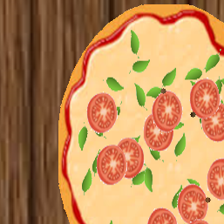

### Visualize data loader

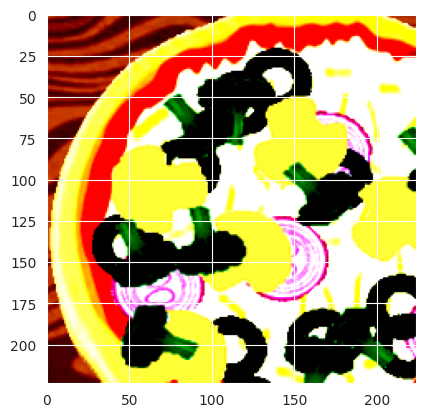

torch.Size([25, 3, 224, 224])


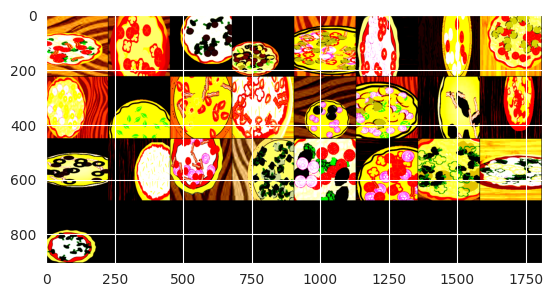

In [10]:
# Show dataset sample
x,y = test_set_raw[45]
#print(x,y)

plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

# Show batch of images
#it = iter(train_dataloader)
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))


## Learning

There are several possibilities to solve the problem:

* Extract good features and apply a simple predictor. The problem is to find good features for the problem: you know what they can be and how to compute them, or you can rely on "generic" features like bag of visual words, histograms or deep features.

* Work on raw data and build the label predictor directly. This is typically an approach for deep learning.

Notice that the problem is **multi-label prediction**, not classification. Each image may be characterized by several labels.


### Compute deep features for images

Example of how to compute deep image features. Here, we use a resnext network, but another may be as good and cheaper to compute and store.

In [11]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat_resnext.npz')

# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from ".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
  resnext = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)

  if device.type == 'cuda':
      resnext = resnext.cuda()

  model = resnext

  # Removes the last classification layer: may different for other network
  modules=list(model.children())[:-1]
  model=nn.Sequential(*modules)
  for p in model.parameters():
      p.requires_grad = False

  # If you need to put the last layer back
  #num_ftrs = resnext.fc.in_features
  #resnext.fc = nn.Linear(num_ftrs, 9)

  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_all, y_all, img_path=train_data_path, img_data=img_all, transform = val_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données
      img, targets = data
      #print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)



Computing image features


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 79.9MB/s]
100%|██████████| 25/25 [00:42<00:00,  1.70s/it]


Storing image features in /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/img_all_feat_resnext.npz


### Learning multi-label from pre-computed features

In [ ]:
# Use the same random seed to generate the same split
feat_train, feat_val, yfeat_train, yfeat_val = train_test_split(feat, y_all, test_size=0.2, random_state=123)

print(feat_train.shape)

# Chexks if labels are the same as the image split
print(np.all(y_val == yfeat_val))

# Use your favorite multilabel predictor...
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score


# Create a multi-output classifier with Logistic Regression as the base estimator
clf = MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=123))

# Train the multi-label predictor
clf.fit(feat_train, yfeat_train)

# Predict labels for the validation set
y_pred = clf.predict(feat_val)


# Compute Average Precision (AP) for each label
ap_scores = []
for i in range(len(yfeat_val[0])):  # Assuming yfeat_val is a list of lists or a NumPy array
    ap_score = average_precision_score(yfeat_val[:, i], y_pred[:, i])
    ap_scores.append(ap_score)

# Compute mean Average Precision (mAP)
mAP = sum(ap_scores) / len(ap_scores)

print("mAP:", mAP)

(3976, 2048)
True
mAP: 0.6028086452256936


### Simple network definition

An elementary convolutional network with input datasize of 32x32.

If you want to  use it, you will need to modify the dataloader.

In [ ]:

# network class
class SimpleCNN(nn.Module):
# Network requires 32x32 input images
  def __init__(self, nlabel = 10):
    super(SimpleCNN, self).__init__()
    self.nlabel = nlabel

    # define here the convolutions and linear layers
    self.conv1 = nn.Conv2d(3,16,3)
    self.conv2 = nn.Conv2d(16,32,3)
    self.conv3 = nn.Conv2d(32,64,3)
    self.lin1 = nn.Linear(256, 128)
    self.lin2 = nn.Linear(128, self.nlabel)

  def forward(self, x):

    # 32x32

    # define here the forward pass
    x1 = self.conv1(x)
    x1r = F.relu(x1)
    x1p = F.max_pool2d(x1r, 2)

    # 16x16
    x2 = self.conv2(x1p)
    x2r = F.relu(x2)
    x2p = F.max_pool2d(x2r, 2)

    # 8x8
    x3 = self.conv3(x2p)
    x3r = F.relu(x3)
    x3p = F.max_pool2d(x3r, 2)

    # 4x4
    y0 = x3p.view(x3p.size(0), -1)

    y1 = self.lin1(y0)
    y1r = F.relu(y1)
    y2 = self.lin2(y1r)

    return y2


In [ ]:
nlabel = y_all.shape[1]
nlabel

10

### Another more complex network

From torchvision.

In [12]:
nlabel = y_all.shape[1]

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

network = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = network.classifier[1].in_features
network.classifier[1]= nn.Linear(num_ftrs, nlabel)

# Name of the network
tag = "efficientNet"

# network = SimpleCNN(nlabel = nlabel)
# # Name of the network
# tag = "simpleCNN"


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 84.7MB/s]


In [24]:
data_iterator = iter(train_dataloader)
inputs, labels = next(data_iterator)
print("Data type of target:", labels.dtype)
labels.size(0)

Data type of target: torch.float32


25

In [25]:
import torch

# Sample tensors
predicted = torch.tensor([[1, 0, 1, 0],
                          [0, 1, 1, 0],
                          [1, 0, 0, 1]])

labels = torch.tensor([[1, 0, 1, 0],
                       [0, 1, 1, 0],
                       [1, 0, 1, 1]])

# Initialize correct_train
correct_train = 0

# Update correct_train based on correct predictions
correct_train += (predicted == labels).all(dim=1).sum().item()

print("Correctly predicted samples in training:", correct_train)


Correctly predicted samples in training: 2


In [41]:
import torch

# Sample tensors
predicted = torch.tensor([[1, 0, 1, 0],
                          [0, 1, 1, 0],
                          [1, 1, 0, 1]])

labels = torch.tensor([[1, 1, 1, 0],
                       [0, 1, 1, 0],
                       [1, 0, 0, 1]])

# Compute accuracy per label
accuracy_per_label = (predicted == labels).float().mean(dim=0)

# Compute overall accuracy
overall_accuracy = accuracy_per_label.mean().item()

print("Accuracy per label:", accuracy_per_label)
print("Overall Accuracy:", overall_accuracy)


Accuracy per label: tensor([1.0000, 0.3333, 1.0000, 1.0000])
Overall Accuracy: 0.8333333730697632


## Learning

Generic function for multi-label learning.

You have to write it!!

In [42]:
#from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

import copy

def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=5):

    # list for saving accuracies
    train_perf = []
    test_perf = []
    train_losses = []

    # iterate over epochs
    for epoch in range(num_epochs):
        print("Epoch {}".format(epoch))

        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            #print("inputs",inputs)
            optimizer.zero_grad()
            #print('labels',labels)
            outputs = model(inputs)
            #print('outputs',outputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            train_loss += loss.item()
            predicted = torch.sigmoid(outputs)
            #print('predicted',predicted)

            predicted = (predicted > 0.30).float()
            #print('predicted',predicted)
            total_train += labels.size(0)
            #correct_train += (predicted == labels).all(dim=1).sum().item()
            # Compute accuracy per label
            accuracy_per_label = (predicted == labels).float().mean(dim=0)

            # Compute overall accuracy
            overall_accuracy = accuracy_per_label.mean().item()



        train_losses.append(train_loss / len(trainloader))
        train_accuracy = overall_accuracy
        train_perf.append(overall_accuracy)

        # Validation phase
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                predicted = torch.sigmoid(outputs)
                predicted = (predicted > 0.20).float()
                #print('predicted',predicted)

                total_test += labels.size(0)
                #correct_test += (predicted == labels).all(dim=1).sum().item()
                # Compute accuracy per label
                accuracy_per_label = (predicted == labels).float().mean(dim=0)

                # Compute overall accuracy
                overall_accuracy = accuracy_per_label.mean().item()


        #test_accuracy = 100 * correct_test / total_test
        test_accuracy=overall_accuracy
        test_perf.append(test_accuracy)

        clear_output(wait=True)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

        scheduler.step()


      # Learning step

    return model, train_perf, test_perf, train_losses



### Example of a code calling the learning function

In [43]:
from torch import nn, optim
from torch.optim import lr_scheduler

# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader

# Read the last learned network (if stored)
#if (os.path.exists(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))):
#    print('Resume from last learning step')
#    network = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# Transfer network to GPU
if torch.cuda.is_available():
    network.to(device)

# Define learning components (to be used in the learning function)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for multi-label classification
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Learning

max_epoch = 20
learned_model, train_error, test_error, train_losses = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

network = learned_model

print("Train accuracies")
print(train_error)
print("Test accuracies")
print(test_error)
print("Train losses")
print(train_losses)



Epoch [20/20], Train Loss: 0.3245, Train Accuracy: 0.70%, Test Accuracy: 0.57%
Train accuracies
[0.800000011920929, 0.5, 0.6000000238418579, 0.5, 0.30000001192092896, 0.699999988079071, 0.6000000238418579, 0.9000000357627869, 0.800000011920929, 0.6000000238418579, 0.5, 0.6000000238418579, 0.6000000238418579, 0.699999988079071, 0.9000000357627869, 0.6000000238418579, 0.5, 0.800000011920929, 0.800000011920929, 0.699999988079071]
Test accuracies
[0.3850000202655792, 0.4749999940395355, 0.4699999988079071, 0.4949999749660492, 0.49000000953674316, 0.5199999809265137, 0.5550000071525574, 0.5550000071525574, 0.5649999976158142, 0.574999988079071, 0.5800000429153442, 0.5649999976158142, 0.5900000333786011, 0.5600000023841858, 0.5700001120567322, 0.5700000524520874, 0.574999988079071, 0.5699999928474426, 0.5950000286102295, 0.5700000524520874]
Train losses
[0.5694771086797118, 0.5625464454293251, 0.5513191241770983, 0.5377067230641842, 0.5256526658311487, 0.46580993141978977, 0.4215938299894333

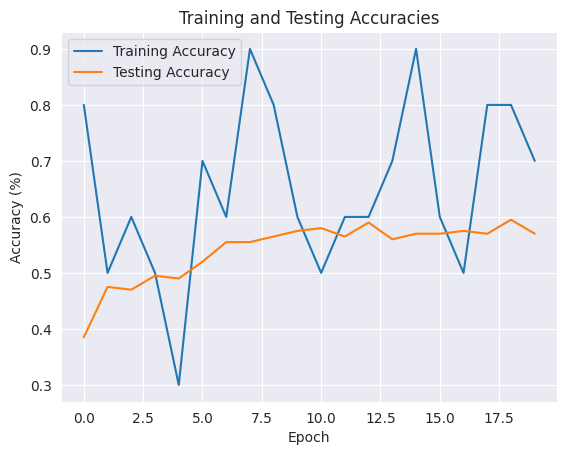

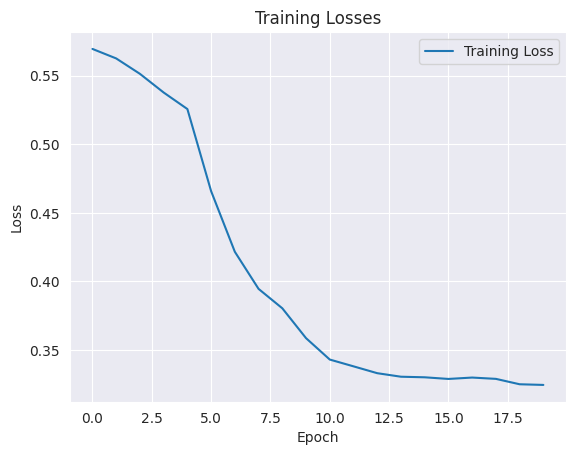

In [44]:
import matplotlib.pyplot as plt

# Assuming train_error, test_error, and train_losses are lists or arrays containing the accuracy and loss values

# Plot training and testing accuracies
plt.plot(train_error, label='Training Accuracy')
plt.plot(test_error, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracies')
plt.legend()
plt.show()

# Plot training losses
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

### Final evaluation

An example of performance computation.

Again, the problem is multi-label prediction, not classification: performance metrics may be different (make a little search to find relevant ones).

In [46]:
import numpy as np
from sklearn.metrics import average_precision_score

testloader = test_dataloader

# Set the model to evaluation mode
network.eval()

# Create the performance array
perf_label_test = np.zeros((1, nlabel))

# Initialize lists to store true and predicted labels
true_labels = []
predicted_probs = []

# Threshold value
threshold = 0.3  # Adjust as needed

# Tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(testloader, ncols=80):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Compute outputs
        outputs = network(inputs)

        # Apply threshold to the predicted probabilities
        predicted_probs_binary = (torch.sigmoid(outputs) > threshold).float()

        # Convert to numpy arrays
        outputs_np = predicted_probs_binary.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()

        # Compute the predicted probabilities
        predicted_probs.append(outputs_np)
        true_labels.append(targets_np)

# Concatenate true labels and predicted probabilities
true_labels = np.concatenate(true_labels)
predicted_probs = np.concatenate(predicted_probs)

# Compute AP for each class
average_precisions = []
for i in range(nlabel):
    average_precisions.append(average_precision_score(true_labels[:, i], predicted_probs[:, i]))

# Compute mAP
mAP = np.mean(average_precisions)

print("Mean Average Precision (mAP):", mAP)


100%|███████████████████████████████████████████| 20/20 [00:07<00:00,  2.62it/s]

Mean Average Precision (mAP): 0.3032046532441219
